In [31]:
import os
import glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.svm import SVC
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    precision_score,
    recall_score,
    f1_score
)

DATA_DIR = "data"

SELECTED_ACTIVITIES = ["sit", "walk", "run", "stairs"]
ALL_POSITIONS = ["dom_hand", "nondom_hand", "dom_pocket", "nondom_pocket", "backpack"]

TRAIN_POSITIONS = ["dom_pocket", "nondom_hand", "nondom_pocket", "backpack"]
TEST_POSITIONS = ["dom_hand"]

SAMPLING_RATE = 100
TRIM_SECONDS = 2
WINDOW_SIZE = SAMPLING_RATE
STEP_SIZE = SAMPLING_RATE // 2

RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

RAW_FEATURES = ["ax", "ay", "az", "gx", "gy", "gz"]
GFT_FEATURES = ["ax_g", "ay_g", "az_g", "gx_g", "gy_g", "gz_g"]

In [2]:
def load_selected_csvs(base_dir):
    dfs = []

    for activity in SELECTED_ACTIVITIES:
        for position in ALL_POSITIONS:
            path = os.path.join(base_dir, activity, position, "*.csv")
            for csv_path in glob.glob(path):
                df = pd.read_csv(csv_path)

                df["activity"] = activity
                df["phone_position"] = position
                df["recording_id"] = os.path.splitext(os.path.basename(csv_path))[0]

                dfs.append(df)

    print(f"Loaded {len(dfs)} recordings | Activities={SELECTED_ACTIVITIES} | Positions={ALL_POSITIONS}")
    return dfs

In [3]:
def trim_df(df):
    trim = SAMPLING_RATE * TRIM_SECONDS
    if len(df) <= 2 * trim:
        return None
    return df.iloc[trim:-trim].reset_index(drop=True)

def sliding_windows(df):
    for start in range(0, len(df) - WINDOW_SIZE + 1, STEP_SIZE):
        yield df.iloc[start:start + WINDOW_SIZE]

In [4]:
def extract_features(window, cols):
    feats = []
    for c in cols:
        x = window[c].values
        feats.extend([
            np.mean(x),
            np.std(x),
            np.min(x),
            np.max(x),
            np.sqrt(np.mean(x ** 2)),      # RMS
            np.sum(np.abs(x)) / len(x)     # SMA
        ])
    return feats

def build_dataset(dfs, feature_cols, selected_positions):
    X, y, groups, positions = [], [], [], []

    for df in dfs:
        if df["phone_position"].iloc[0] not in selected_positions:
            continue

        df = trim_df(df)
        if df is None:
            continue

        for w in sliding_windows(df):
            X.append(extract_features(w, feature_cols))
            y.append(w["activity"].iloc[0])
            groups.append(w["recording_id"].iloc[0])
            positions.append(w["phone_position"].iloc[0])

    return np.array(X), np.array(y), np.array(groups), np.array(positions)

In [32]:
def train_test_svm(X_train, y_train, X_test, y_test, title):
    model = Pipeline([
        ("scaler", StandardScaler()),
        ("svm", SVC(kernel="rbf", C=1, gamma="scale"))
    ])
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    print(f"\n=== {title} ===")
    unique_labels = np.unique(y_test)
    print(classification_report(y_test, y_pred, labels=unique_labels, digits=4, zero_division=0))

    cm = confusion_matrix(y_test, y_pred, labels=unique_labels)
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt="d", xticklabels=unique_labels, yticklabels=unique_labels, cmap="Blues")
    plt.title(title)
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.tight_layout()
    plt.show()

    return {
        "precision": precision_score(y_test, y_pred, average="macro", zero_division=0),
        "recall": recall_score(y_test, y_pred, average="macro", zero_division=0),
        "f1": f1_score(y_test, y_pred, average="macro", zero_division=0)
    }

Loaded 100 recordings | Activities=['sit', 'walk', 'run', 'stairs'] | Positions=['dom_hand', 'nondom_hand', 'dom_pocket', 'nondom_pocket', 'backpack']

=== SVM – Raw Device-Frame Features ===
              precision    recall  f1-score   support

         run     0.9540    0.9960    0.9746       250
         sit     0.6361    1.0000    0.7776       250
      stairs     0.9906    0.4118    0.5817       255
        walk     0.5224    0.5120    0.5172       250

    accuracy                         0.7284      1005
   macro avg     0.7758    0.7299    0.7128      1005
weighted avg     0.7769    0.7284    0.7121      1005



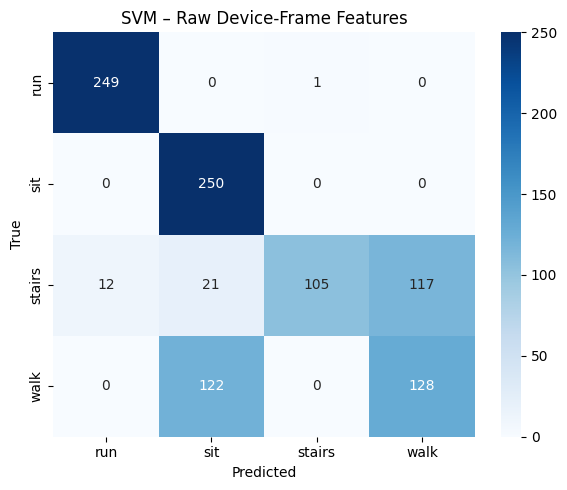


=== SVM – GFT Axis-wise Features ===
              precision    recall  f1-score   support

         run     0.9615    0.2000    0.3311       250
         sit     0.8893    0.9960    0.9396       250
      stairs     0.3358    0.5373    0.4133       255
        walk     0.5585    0.5920    0.5748       250

    accuracy                         0.5811      1005
   macro avg     0.6863    0.5813    0.5647      1005
weighted avg     0.6845    0.5811    0.5639      1005



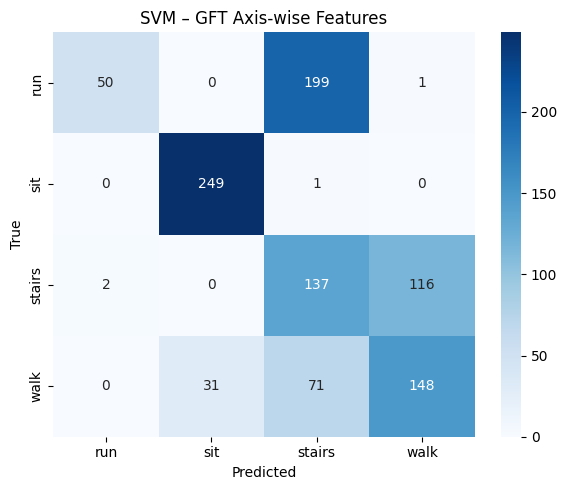


========== SUMMARY ==========
Activities: ['sit', 'walk', 'run', 'stairs']
Train Positions: ['dom_pocket', 'nondom_hand', 'nondom_pocket', 'backpack']
Test Positions: ['dom_hand']
Raw Device-Frame Features: {'precision': 0.7757925803387653, 'recall': 0.7299411764705882, 'f1': 0.7127634580638917}
GFT Axis-wise Features: {'precision': 0.6862747638968505, 'recall': 0.5813137254901961, 'f1': 0.5646946880964242}


In [33]:
if __name__ == "__main__":
    recordings = load_selected_csvs(DATA_DIR)

    # Phone-frame data
    X_train_raw, y_train_raw, _, _ = build_dataset(recordings, RAW_FEATURES, TRAIN_POSITIONS)
    X_test_raw, y_test_raw, _, _ = build_dataset(recordings, RAW_FEATURES, TEST_POSITIONS)
    raw_metrics = train_test_svm(X_train_raw, y_train_raw, X_test_raw, y_test_raw, "SVM – Raw Device-Frame Features")

    # Global-frame data
    X_train_gft, y_train_gft, _, _ = build_dataset(recordings, GFT_FEATURES, TRAIN_POSITIONS)
    X_test_gft, y_test_gft, _, _ = build_dataset(recordings, GFT_FEATURES, TEST_POSITIONS)
    gft_metrics = train_test_svm(X_train_gft, y_train_gft, X_test_gft, y_test_gft, "SVM – GFT Axis-wise Features")

    print("\n========== SUMMARY ==========")
    print("Activities:", SELECTED_ACTIVITIES)
    print("Train Positions:", TRAIN_POSITIONS)
    print("Test Positions:", TEST_POSITIONS)
    print("Raw Device-Frame Features:", raw_metrics)
    print("GFT Axis-wise Features:", gft_metrics)